In [1]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import signal
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = '../fma_small/000/*.mp3'
music = [AudioSegment.from_file(files) for files in glob(path)]

/Users/wjr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


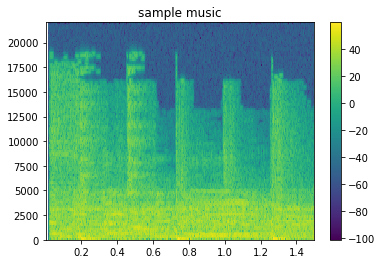

(129, 515)


In [74]:
sample = np.array(music[0].get_array_of_samples())
sample = [sample[i] for i in range(0,3*44100,2)] #get left channel only
Fs = music[0].frame_rate
sample = sample[:int(Fs*1.5)]
spec, freqs, bins, im = plt.specgram(sample, Fs=Fs)
plt.colorbar()
plt.title('sample music')
plt.show()
print(spec.shape)
tag = mediainfo('fma_small/000/000002.mp3')



In [75]:
WIDTH = 128
HEIGHT = 512
LENGTH = int(1.5*Fs)
INPUT_LEN = 30*Fs
INTERVAL = int(0.05*Fs) #in seconds, determines how many fingerprints each song will generate

def _parse_audio(music, path, k):
    ## music: raw music array from file
    ## path: path that contains the label of the music
    ## k: batch size
    batch = []
    label = []
    for i in range(len(music)):
        temp = np.array(music[i].get_array_of_samples())
        if len(temp) > INPUT_LEN: #check if the audio has two channels
            temp = [temp[i] for i in range(0,10*Fs,2)] #get left channel only
            
        # convert to fingerprints
        num_fp = int((len(temp)-LENGTH)/INTERVAL)+1
        for j in range(num_fp):
            segment = temp[j*INTERVAL:j*INTERVAL+LENGTH]
            cur_spec, freqs, bins, im = plt.specgram(segment, Fs=Fs)
            cur_spec = cur_spec[:WIDTH, :HEIGHT] #truncate to power of 2            
            batch.append(cur_spec)
        
        # discard last few elements
        # create label for the current music (modify so that only nearby segment have the same label)
        label += [int(str(glob(path)[i])[17:23])] * (num_fp)
    
    # shuffle all samples
    batch = np.asarray(batch)
    label = np.asarray(label)
    s = np.arange(batch.shape[0])
    np.random.shuffle(s)
    batch = batch[s]
    label = label[s]
    
    # create k-size batches
    num_batch = int(batch.shape[0]/k)
    batch = batch[:num_batch*k]
    batch = batch.reshape(num_batch, k, WIDTH, HEIGHT, 1)
    batch = [batch[i]/np.amax(batch[i]) for i in range(batch.shape[0])]
    
    return np.asarray(batch), label

In [29]:
batch, label = _parse_audio(music[:1], path, 50)

/Users/wjr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [35]:
batch.shape

(11, 50, 128, 512, 1)

In [72]:
temppath = '../../Right Here Waiting.mp3'
sound = AudioSegment.from_file(temppath)
sample = np.array(sound.get_array_of_samples())
sample = sample[:10*Fs] #get left channel only
sample = [sample[i] for i in range(0,10*Fs,2)]
Audio(data=sample, rate=Fs)